# Check Water Use Formulas and Alternatives

The idea for this notebook is the check the differences in water use risk for a given commodity (soy) based in if the water map used is the especific for that commodity, or if it's the default water use map.  
We apply the water risk formula with each of them and compare the results.

In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import rasterio as rio
import rasterio.plot
import matplotlib.pyplot as plt
from rasterio.plot import show_hist
import time
from rasterstats import gen_zonal_stats, gen_point_query, zonal_stats
from shapely.geometry import shape, mapping
import folium
import numpy as np
import rioxarray

### Preparation of blue water footprint maps  


First, the especific map of soy water footprint (using always the **blue water footprint**)  
Change projection to EPSG 4326 (well,original map already has it) and muptiply by 103 (unit conversion factor)

In [2]:
blwf_soy_orig='../../datasets/raw/Water/Reports_Commodities/Soybean/wfbl_mmyr/hdr.adf'
blwf_soy_p='../../datasets/raw/Water/Reports_Commodities/Soybean/wfbl_soyb_epsg4326.tif'
!rm -rf $blwf_soy_p
!gdal_translate -a_srs EPSG:4326 -of GTiff $blwf_soy_orig $blwf_soy_p
!gdal_calc.py -A $blwf_soy_p --outfile $blwf_soy_p --calc 'A*103' --overwrite --quiet

Input file size is 4320, 1668
0...10...20...30...40...50...60...70...80...90...100 - done.
<string>:1: RuntimeWarning: overflow encountered in multiply
/opt/conda/lib/python3.8/site-packages/osgeo/utils/gdal_calc.py:367: RuntimeWarning: invalid value encountered in multiply
  myResult = ((1 * (myNDVs == 0)) * myResult) + (myOutNDV * myNDVs)


In [3]:
!gdalinfo -stats $blwf_soy_p

Driver: GTiff/GeoTIFF
Files: ../../datasets/raw/Water/Reports_Commodities/Soybean/wfbl_soyb_epsg4326.tif
       ../../datasets/raw/Water/Reports_Commodities/Soybean/wfbl_soyb_epsg4326.tif.aux.xml
Size is 4320, 1668
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (-179.991666649999985,83.088333349999431)
Pixel Size = (0.083333333333333,-0.083333333333333)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (-179.991666

Now the same for the **default** water footprint map

In [4]:
blwf_default_orig='../../datasets/raw/Water/Report50-WF-of-prodn-RasterFiles/wf_bltot_mmyr/hdr.adf'
blwf_default_p='../../datasets/raw/Water/Report50-WF-of-prodn-RasterFiles/wf_bltot_mmyr/wfbl_default_epsg4326.tif'

!rm -rf $blwf_default_p
!gdal_translate -a_srs EPSG:4326 -of GTiff $blwf_default_orig $blwf_default_p
!gdal_calc.py -A $blwf_default_p --outfile $blwf_default_p --calc 'A*103' --overwrite --quiet

Input file size is 4320, 1668
0...10...20...30...40...50...60...70...80...90...100 - done.
<string>:1: RuntimeWarning: overflow encountered in multiply
/opt/conda/lib/python3.8/site-packages/osgeo/utils/gdal_calc.py:367: RuntimeWarning: invalid value encountered in multiply
  myResult = ((1 * (myNDVs == 0)) * myResult) + (myOutNDV * myNDVs)


In [5]:
!gdalinfo -stats $blwf_default_p

Driver: GTiff/GeoTIFF
Files: ../../datasets/raw/Water/Report50-WF-of-prodn-RasterFiles/wf_bltot_mmyr/wfbl_default_epsg4326.tif
       ../../datasets/raw/Water/Report50-WF-of-prodn-RasterFiles/wf_bltot_mmyr/wfbl_default_epsg4326.tif.aux.xml
Size is 4320, 1668
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (-179.991666649999985,83.088344470000010)
Pixel Size = (0.083333340000000,-0.083333340000000)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=BAND


### Crop production data to match water raster extent
Use top left and bottom right corners from water map

In [6]:
prod_soy_orig='../../datasets/raw/spam2010v2r0_global_prod.geotiff/spam2010V2r0_global_P_SOYB_A.tif'
prod_soy_p='../../datasets/raw/spam2010v2r0_global_prod.geotiff/spam2010V2r0_global_P_SOYB_A_new_extent.tif'

!rm -rf $prod_soy_p
!gdal_translate -projwin -179.9916666 83.0883333 180.0083333 -55.9116667 -of GTiff $prod_soy_orig $prod_soy_p

#Remove pixels with codified NA value (-1)
#!gdal_calc.py -A $prod_soy_p --outfile $prod_soy_p --calc 'A*(A>0)' --overwrite --quiet

Input file size is 4320, 2160
0...10...20...30...40...50...60...70...80...90...100 - done.


In [7]:
!gdalinfo -stats $prod_soy_p


Driver: GTiff/GeoTIFF
Files: ../../datasets/raw/spam2010v2r0_global_prod.geotiff/spam2010V2r0_global_P_SOYB_A_new_extent.tif
       ../../datasets/raw/spam2010v2r0_global_prod.geotiff/spam2010V2r0_global_P_SOYB_A_new_extent.tif.aux.xml
Size is 4320, 1668
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (-180.000000000000000,83.166694000000007)
Pixel Size = (0.083333000000000,-0.083333000000000)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=BAND
Corn

In [8]:
# for lack of a better method: production = width * height * pct of valid pixels * mean
tot_prod = 4320 * 1668 * 0.1156 * 300.32094059949

print(f'Total production: {tot_prod}')

Total production: 250163095.77999127


### Calculate risk maps

In [ ]:
!mkdir '../../datasets/processed/water_indicators'

FOR THE ESPECIFIC MAP

In [9]:
!gdal_calc.py -A $blwf_soy_p -B $prod_soy_p  --outfile='../../datasets/processed/water_indicators/water_risk_soy_especific.tif' --calc="(A*B)/250163095.77999127" --overwrite --quiet

In [10]:
!gdalinfo -stats '../../datasets/processed/water_indicators/water_risk_soy_especific.tif'

Driver: GTiff/GeoTIFF
Files: ../../datasets/processed/water_indicators/water_risk_soy_especific.tif
       ../../datasets/processed/water_indicators/water_risk_soy_especific.tif.aux.xml
Size is 4320, 1668
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (-179.991666649999985,83.088333349999431)
Pixel Size = (0.083333333333333,-0.083333333333333)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (-179.9916666,  83.088

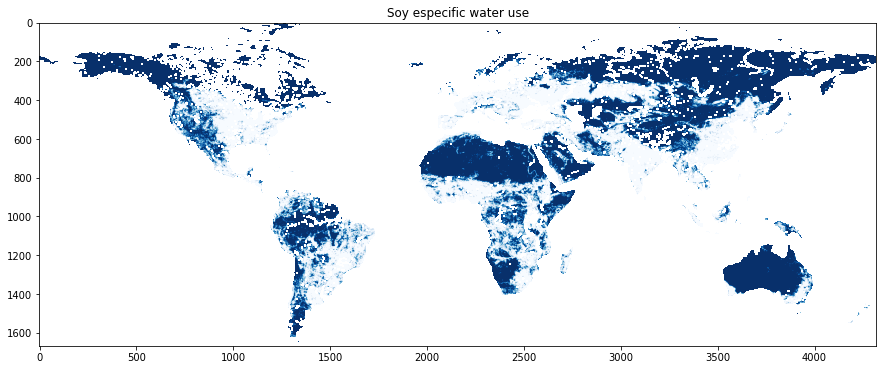

In [11]:
with rio.open('../../datasets/processed/water_indicators/water_risk_soy_especific.tif') as src:
    image_array = src.read(1)
    #msk = src.read_masks()
    fig, ax = plt.subplots(figsize=[15,10])
    rio.plot.show(image_array, vmin=1, cmap='Blues' , ax=ax)
    ax.set_title('Soy especific water use')


FOR THE DEFAULT MAP  
In this case, we need to filter the default water map by the places where there is soy production

In [12]:
!gdal_calc.py -A $blwf_default_p -B $prod_soy_p  --outfile='../../datasets/processed/water_indicators/water_risk_soy_default.tif' --calc="((A*(B>0))*B)/250163095.77999127" --overwrite --quiet

In [13]:
!gdalinfo -stats '../../datasets/processed/water_indicators/water_risk_soy_default.tif'

Driver: GTiff/GeoTIFF
Files: ../../datasets/processed/water_indicators/water_risk_soy_default.tif
       ../../datasets/processed/water_indicators/water_risk_soy_default.tif.aux.xml
Size is 4320, 1668
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (-179.991666649999985,83.088344470000010)
Pixel Size = (0.083333340000000,-0.083333340000000)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (-179.9916666,  83.0883445

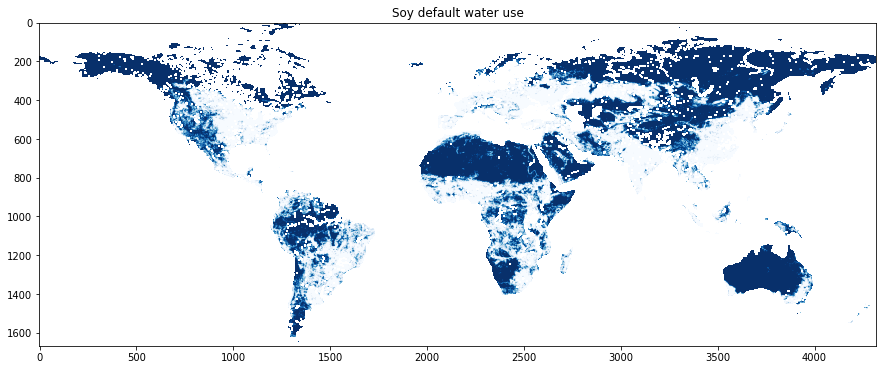

In [15]:
with rio.open('../../datasets/processed/water_indicators/water_risk_soy_default.tif') as src:
    image_array = src.read(1)
    #msk = src.read_masks()
    fig, ax = plt.subplots(figsize=[15,10])
    rio.plot.show(image_array, vmin=1, cmap='Blues' , ax=ax)
    ax.set_title('Soy default water use')

### Calculate differences  
formula used: $\frac{Especific - Default}{Especific}$

In [6]:
especific_map='../../datasets/processed/water_indicators/water_risk_soy_especific.tif'
default_map='../../datasets/processed/water_indicators/water_risk_soy_default.tif'

!gdal_calc.py -A $especific_map -B $default_map  --outfile='../../datasets/processed/water_indicators/water_risk_soy_DIFF_esp-def.tif' --calc="(A-B)/A" --overwrite --quiet

<string>:1: RuntimeWarning: invalid value encountered in true_divide
<string>:1: RuntimeWarning: divide by zero encountered in true_divide


In [7]:
!gdalinfo -stats '../../datasets/processed/water_indicators/water_risk_soy_DIFF_esp-def.tif'

Driver: GTiff/GeoTIFF
Files: ../../datasets/processed/water_indicators/water_risk_soy_DIFF_esp-def.tif
       ../../datasets/processed/water_indicators/water_risk_soy_DIFF_esp-def.tif.aux.xml
Size is 4320, 1668
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (-179.991666649999985,83.088333349999431)
Pixel Size = (0.083333333333333,-0.083333333333333)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (-179.9916666,  

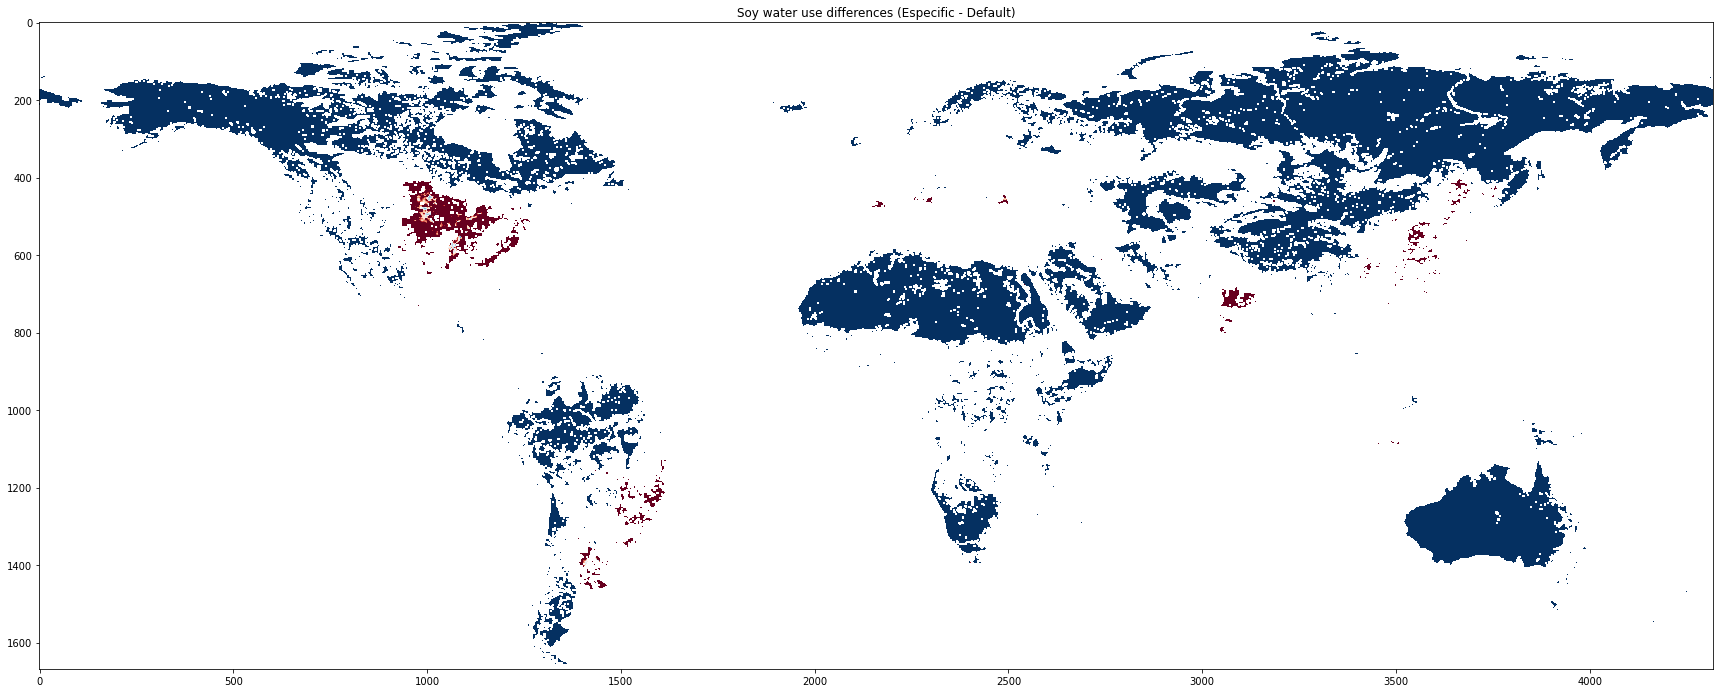

In [15]:
with rio.open('../../datasets/processed/water_indicators/water_risk_soy_DIFF_esp-def.tif') as src:
    image_array = src.read(1)
    #msk = src.read_masks()
    fig, ax = plt.subplots(figsize=[30,20])
    rio.plot.show(image_array,vmin=-4, cmap='RdBu' , ax=ax)
    ax.set_title('Soy water use differences (Especific - Default)')

## Compare values

Create a dataframe to better understand the range of differences between especiific and default water risks. To simplyfy, the dataframe is built for a extent covering US and nearby land, sellecting pixels where soy production is > 1tn and differences in risk are not greater than 10 times the especific risk values.

In [6]:
especific_map='../../datasets/processed/water_indicators/water_risk_soy_especific.tif'
default_map='../../datasets/processed/water_indicators/water_risk_soy_default.tif'
prod_soy_p='../../datasets/raw/spam2010v2r0_global_prod.geotiff/spam2010V2r0_global_P_SOYB_A_new_extent.tif'
diff_map='../../datasets/processed/water_indicators/water_risk_soy_DIFF_esp-def.tif'

#!gdal2xyz.py -csv $diff_map '../../datasets/processed/water_indicators/differences_soy.csv'

First, transform the differences raster into a (cropped) XYZ file, so it can be loaded as a dataframe

In [7]:
!gdal_translate -projwin -126 49 -72 25 -of 'xyz' $diff_map '../../datasets/processed/water_indicators/differences_soy.xyz'

Input file size is 4320, 1668
0...10...20...30...40...50...60...70...80...90...100 - done.


In [45]:
diff=pd.read_csv('../../datasets/processed/water_indicators/differences_soy.xyz', sep=" ", header=None)
diff.columns=["X", "Y", "difference"]
diff.dropna(inplace=True)
diff.describe()

,X,Y,difference
count,89922.000000,89922.000000,8.992200e+04
mean,-97.254669,38.876707,-inf
std,13.370532,6.002629,NaN
min,-125.533333,25.046667,-inf
25%,-108.533333,34.546667,-8.543826e+01
50%,-96.950000,39.380000,-1.654380e+00
75%,-86.033333,43.713333,0.000000e+00
max,-72.116667,48.963333,0.000000e+00


In [87]:
diff[(diff['difference'] > -10) & (diff['difference'] < 0)].head()

,X,Y,difference
4901,-95.62,48.38,-9.604154
6827,-97.12,48.13,-7.468331
6828,-97.03,48.13,-4.611923
6829,-96.95,48.13,-4.273904
6830,-96.87,48.13,-4.388415


In [56]:
diff[(diff['difference'] > -10)].describe()

,X,Y,difference
count,55202.000000,55202.000000,55202.000000
mean,-102.916260,39.167698,-0.957373
std,12.978602,6.409059,2.222186
min,-125.530000,25.050000,-9.998277
25%,-113.200000,34.380000,0.000000
50%,-105.870000,39.960000,0.000000
75%,-94.120000,44.550000,0.000000
max,-72.120000,48.960000,0.000000


Transform both risks maps and the production map (only production map has been later used in this example)

In [15]:
print('Saving especific data')
!gdal_translate -projwin -126 49 -72 25 -of 'xyz' $especific_map '../../datasets/processed/water_indicators/risk_especific_soy.xyz'
print('Saving default data')
!gdal_translate -projwin -126 49 -72 25 -of 'xyz' $default_map '../../datasets/processed/water_indicators/risk_default_soy.xyz'
print('Saving production data')
!gdal_translate -projwin -126 49 -72 25 -of 'xyz' $prod_soy_p '../../datasets/processed/water_indicators/production_soy.xyz'
print('All done')

Saving especific data
Input file size is 4320, 1668
0...10...20...30...40...50...60...70...80...90...100 - done.
Saving default data
Input file size is 4320, 1668
0...10...20...30...40...50...60...70...80...90...100 - done.
Saving production data
Input file size is 4320, 1668
0...10...20...30...40...50...60...70...80...90...100 - done.
All done


In [24]:
#esp=pd.read_csv('../../datasets/processed/water_indicators/risk_especific_soy.xyz', sep=" ", header=None)
#esp.columns=["X", "Y", "esp_risk"]
#esp.dropna(inplace=True)

#dflt=pd.read_csv('../../datasets/processed/water_indicators/risk_especific_soy.xyz', sep=" ", header=None)
#dflt.columns=["X", "Y", "dflt_risk"]
#dflt.dropna(inplace=True)

prod=pd.read_csv('../../datasets/processed/water_indicators/production_soy.xyz', sep=" ", header=None)
prod.columns=["X", "Y", "production_soy"]
prod.dropna(inplace=True)

In [30]:
prod[prod['production_soy']>1].describe()

,X,Y,production_soy
count,45048.000000,45048.000000,45048.000000
mean,-89.536414,39.243173,2045.920975
std,7.707292,4.939934,2627.062358
min,-110.041946,25.291926,1.100000
25%,-96.375334,35.791884,76.000000
50%,-90.125360,39.708535,729.349976
75%,-83.375386,43.041855,3380.299988
max,-72.042098,48.958498,36800.898438


Join both datasets by index (note: joining by coordinates didn't worked properly)  
Create a clean dataframe with cases where production > 1tn and differences < 10 times greater (> -10 because they are all negative values)

In [57]:
prod=prod.round({'X':2, 'Y':2})
diff=diff.round({'X':2, 'Y':2})
df_combined=prod.merge(diff['difference'], left_index=True, right_index=True, how='inner')
df_combined_clean=df_combined[(df_combined['production_soy']>1) & (df_combined['difference'] > -10)] 
df_combined_clean.head()

,X,Y,production_soy,difference
352,-96.63,48.96,8.200000,0.0
353,-96.54,48.96,4.100000,0.0
1006,-96.13,48.88,1174.199951,0.0
1014,-95.46,48.88,3.700000,0.0
1096,-88.63,48.88,16.500000,0.0


In [58]:
df_combined_clean.describe()

,X,Y,production_soy,difference
count,12010.000000,12010.000000,12010.000000,12010.000000
mean,-93.149123,41.010784,3859.473206,-4.309352
std,5.779124,3.769613,2750.514817,2.766869
min,-109.960000,25.380000,1.100000,-9.998277
25%,-97.290000,38.710000,1419.699951,-6.560200
50%,-94.790000,41.130000,3792.500000,-3.807894
75%,-89.960000,43.960000,5988.299927,-2.191409
max,-72.040000,48.960000,17557.699219,0.000000


In [77]:
df_combined_clean[df_combined_clean['difference'] != 0].describe()

,X,Y,production_soy,difference
count,10861.000000,10861.000000,10861.000000,10861.000000
mean,-93.919715,41.067490,4212.267766,-4.765244
std,4.761545,3.517652,2631.363702,2.508564
min,-103.290000,29.880000,1.800000,-9.998277
25%,-97.460000,38.880000,2052.500000,-6.867135
50%,-95.210000,41.130000,4138.399902,-4.260152
75%,-90.540000,43.790000,6208.500000,-2.567209
max,-75.130000,48.130000,17557.699219,-0.595164


Text(0, 0.5, 'Production')

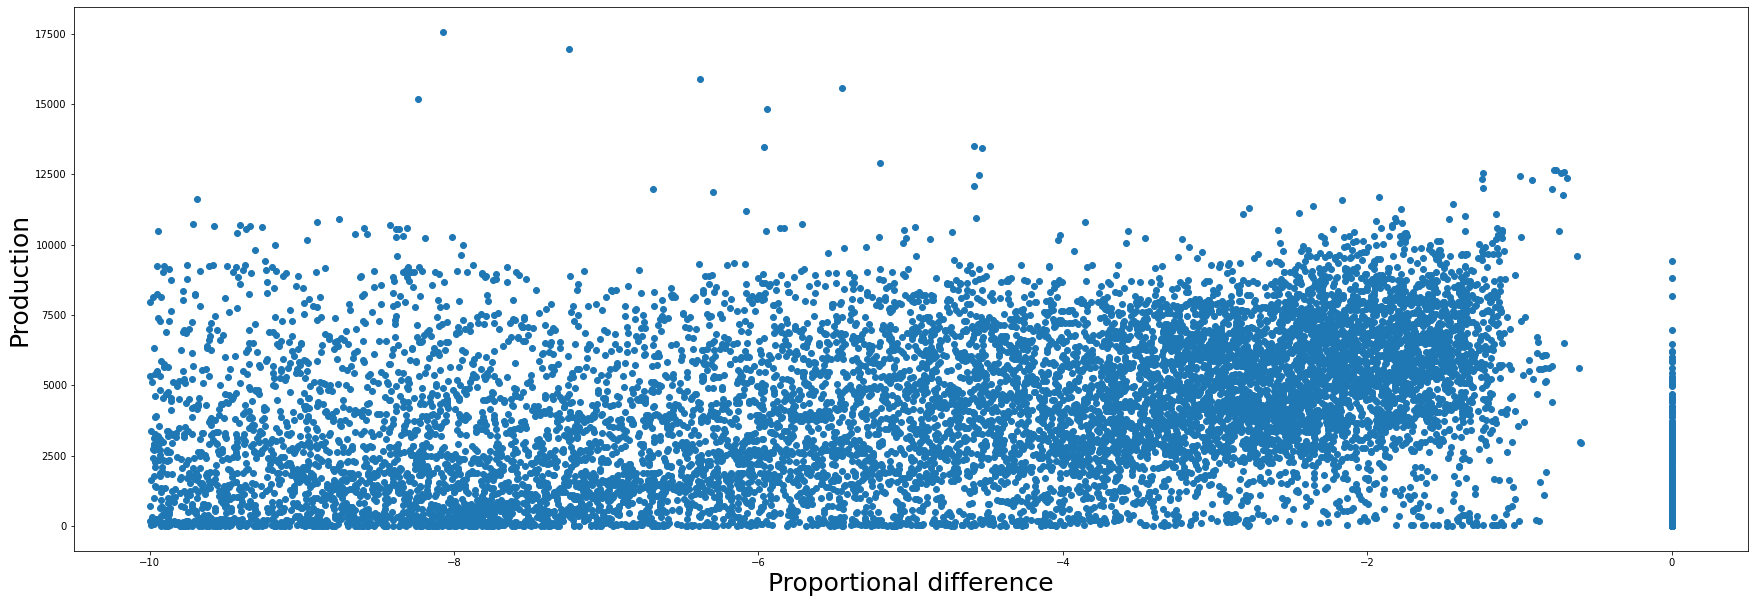

In [88]:
fig, ax = plt.subplots(figsize=[30,10])
x=df_combined_clean['difference']
y=df_combined_clean['production_soy']
plt.scatter(x, y, vmin = -10, vmax=0)
plt.xlabel('Proportional difference', fontsize = 25)
plt.ylabel('Production', fontsize = 25)